In [2]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By # used to import different ways to access data in the XML or HTML file
from selenium.webdriver.chrome.service import Service # no longer need to download a driver file, use service
from webdriver_manager.chrome import ChromeDriverManager # used to manage the Chrome driver to emulate a Chrome web browser
import time
import random

In [3]:
import random, time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

def random_scroll(driver, duration):
    """
    Slowly scrolls the page over `duration` seconds to mimic human behavior.
    """
    start = time.time()
    end   = start + duration
    while time.time() < end:
        driver.execute_script("window.scrollBy(0, window.innerHeight*0.1);")
        time.sleep(random.uniform(0.2, 0.5))

driver = webdriver.Chrome()
driver.get(
    "https://apps.bea.gov/iTable/?reqid=19&step=3&isuri=1&1921=survey&1903=11"
    "#eyJhcHBpZCI6MTksInN0ZXBzIjpbMSwyLDMsM10sImRhdGEiOltbIk5JUEFfVGFibGVfTGlzdCIsIjQyNCJdLFsiQ2F0ZWdvcmllcyIsIlN1cnZleSJdLFsiRmlyc3RfWWVhciIsIjIwMTAiXSxbIkxhc3RfWWVhciIsIjIwMjUiXSxbIlNjYWxlIiwiMCJdLFsiU2VyaWVzIiwiTSJdXX0="
)


WebDriverWait(driver, 20).until(
    EC.presence_of_element_located((By.ID, "DataTbl_wrapper"))
)

random_scroll(driver, random.uniform(3, 5))

body_table = driver.find_element(
    By.CSS_SELECTOR, "#DataTbl_wrapper .dataTables_scrollBody table"
)
row11 = body_table.find_element(
    By.XPATH, ".//tbody/tr[td[1][normalize-space(.)='11']]"
)
cells  = row11.find_elements(By.TAG_NAME, "td")
all_values = [float(td.text) for td in cells[2:]]  # drop the "11" & label


start_year, end_year = 2010, 2024
num_years = end_year - start_year + 1   # 15
n_months  = num_years * 12               # 180

values = all_values[:n_months]

month_order = ["JAN","FEB","MAR","APR","MAY","JUN",
               "JUL","AUG","SEP","OCT","NOV","DEC"]
years  = [str(y) for y in range(start_year, end_year+1) for _ in range(12)]
months = month_order * num_years

print("Years:",  years[:12],  "... total:", len(years))
print("Months:", months[:12], "... total:", len(months))

df_monthly = pd.DataFrame({
    "Year":  years,
    "Month": months,
    "Value": values
})

display(df_monthly)

driver.quit()


Years: ['2010', '2010', '2010', '2010', '2010', '2010', '2010', '2010', '2010', '2010', '2010', '2010'] ... total: 180
Months: ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'] ... total: 180


,Year,Month,Value
0,2010,JAN,-0.1
1,2010,FEB,-3.7
2,2010,MAR,-2.6
3,2010,APR,-0.6
4,2010,MAY,-0.8
...,...,...,...
175,2024,AUG,0.0
176,2024,SEP,1.6
177,2024,OCT,-0.2
178,2024,NOV,-0.1


In [4]:
# 1) Export to a CSV file
df_monthly.to_csv('monthly_inflation.csv', index=False)


In [5]:
# Read the raw CSV into df_tesla
df_tesla = pd.read_csv("tesla_stock_data_2000_2025.csv")

df_tesla = df_tesla.iloc[2:].reset_index(drop=True)

df_tesla = df_tesla.rename(columns={"Price": "Date"})
df_tesla["Date"] = pd.to_datetime(df_tesla["Date"])

df_tesla

,Date,Close,High,Low,Open,Volume
0,2010-06-29,1.5926669836044312,1.6666669845581055,1.1693329811096191,1.2666670083999634,281494500
1,2010-06-30,1.5886670351028442,2.0280001163482666,1.553333044052124,1.7193330526351929,257806500
2,2010-07-01,1.4639999866485596,1.7280000448226929,1.3513330221176147,1.6666669845581055,123282000
3,2010-07-02,1.2799999713897705,1.5399999618530273,1.24733304977417,1.5333329439163208,77097000
4,2010-07-06,1.0740000009536743,1.3333330154418945,1.0553330183029175,1.3333330154418945,103003500
...,...,...,...,...,...,...
3687,2025-02-25,302.79998779296875,328.8900146484375,297.25,327.0199890136719,134228800
3688,2025-02-26,290.79998779296875,309.0,288.0400085449219,303.7099914550781,100118300
3689,2025-02-27,281.95001220703125,297.2300109863281,280.8800048828125,291.1600036621094,101748200
3690,2025-02-28,292.9800109863281,293.8800048828125,273.6000061035156,279.5,115397200


In [6]:
for col in ["Close","High","Low","Open","Volume"]:
    df_tesla[col] = pd.to_numeric(df_tesla[col], errors="coerce")

# Extract Year and Month (3-letter uppercase) from the Date
df_tesla["Year"]  = df_tesla["Date"].dt.year.astype(str)
df_tesla["Month"] = df_tesla["Date"].dt.strftime("%b").str.upper()

merged = pd.merge(
    df_tesla,
    df_monthly[["Year","Month","Value"]],
    on=["Year","Month"],
    how="left"
)

print(merged.shape)
merged.head()

(3692, 9)


,Date,Close,High,Low,Open,Volume,Year,Month,Value
0,2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500,2010,JUN,0.3
1,2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500,2010,JUN,0.3
2,2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000,2010,JUL,0.1
3,2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000,2010,JUL,0.1
4,2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500,2010,JUL,0.1


In [7]:
# 1) Define your quarter map
q_map = {
    "JAN":1,"FEB":1,"MAR":1,
    "APR":2,"MAY":2,"JUN":2,
    "JUL":3,"AUG":3,"SEP":3,
    "OCT":4,"NOV":4,"DEC":4
}

# 2) Build a Quarter column off your existing Month
merged['Quarter'] = merged['Month'].map(q_map)

# 3) Read your Tesla quarterly EPS/Revenue file
tesla_rev_eps = pd.read_csv('tesla_rev_eps.csv', parse_dates=['Date'])

# 4) On the quarterly df, extract year & quarter too
tesla_rev_eps['Year']    = tesla_rev_eps['Date'].dt.year
tesla_rev_eps['Quarter'] = tesla_rev_eps['Date'].dt.quarter
merged['Year'] = merged['Year'].astype(int)

# Make sure the quarterly DF’s Year is integer too
tesla_rev_eps['Year'] = tesla_rev_eps['Date'].dt.year.astype(int)

# Likewise for Quarter (just to be safe)
merged['Quarter']        = merged['Quarter'].astype(int)
tesla_rev_eps['Quarter'] = tesla_rev_eps['Date'].dt.quarter.astype(int)

# 5) Merge on Year & Quarter
tesla = merged.merge(
    tesla_rev_eps[['Year','Quarter','EPS','Revenue']],
    on=['Year','Quarter'],
    how='left',
    validate='m:1'   # many daily rows per quarter → one Tesla row
)

# 6) (Optional) Drop the helper cols if you don’t need them
tesla = tesla.drop(columns=['Year','Month'])
display(tesla)

/var/folders/26/v6bry8wj6yn17rfht8413jyr0000gn/T/ipykernel_33907/3078146873.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tesla_rev_eps = pd.read_csv('tesla_rev_eps.csv', parse_dates=['Date'])


,Date,Close,High,Low,Open,Volume,Value,Quarter,EPS,Revenue
0,2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500,0.3,2,-0.34,28.0
1,2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500,0.3,2,-0.34,28.0
2,2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000,0.1,3,-0.03,31.0
3,2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000,0.1,3,-0.03,31.0
4,2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500,0.1,3,-0.03,31.0
...,...,...,...,...,...,...,...,...,...,...
3687,2025-02-25,302.799988,328.890015,297.250000,327.019989,134228800,NaN,1,NaN,NaN
3688,2025-02-26,290.799988,309.000000,288.040009,303.709991,100118300,NaN,1,NaN,NaN
3689,2025-02-27,281.950012,297.230011,280.880005,291.160004,101748200,NaN,1,NaN,NaN
3690,2025-02-28,292.980011,293.880005,273.600006,279.500000,115397200,NaN,1,NaN,NaN


In [8]:
# make sure Date is datetime-typed
tesla['Date'] = pd.to_datetime(tesla['Date'])

# filter for 2019
tesla_2019 = tesla[ tesla['Date'].dt.year == 2019 ]
display(tesla_2019.head(100))

,Date,Close,High,Low,Open,Volume,Value,Quarter,EPS,Revenue
2142,2019-01-02,20.674667,21.008667,19.920000,20.406668,174879000,0.1,1,-0.27,4541.0
2143,2019-01-03,20.024000,20.626667,19.825333,20.466667,104478000,0.1,1,-0.27,4541.0
2144,2019-01-04,21.179333,21.200001,20.181999,20.400000,110911500,0.1,1,-0.27,4541.0
2145,2019-01-07,22.330667,22.449333,21.183332,21.448000,113268000,0.1,1,-0.27,4541.0
2146,2019-01-08,22.356667,22.934000,21.801332,22.797333,105127500,0.1,1,-0.27,4541.0
...,...,...,...,...,...,...,...,...,...,...
2237,2019-05-20,13.690667,13.733333,13.016667,13.520000,307893000,-0.9,2,-0.15,6350.0
2238,2019-05-21,13.672000,13.826667,13.069333,13.184000,270058500,-0.9,2,-0.15,6350.0
2239,2019-05-22,12.848667,13.596000,12.785333,13.273333,280278000,-0.9,2,-0.15,6350.0
2240,2019-05-23,13.032667,13.298000,12.414667,12.956000,398206500,-0.9,2,-0.15,6350.0


In [9]:
# 1) Export to a CSV file
tesla.to_csv('tesla.csv', index=False)

# Univariate

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

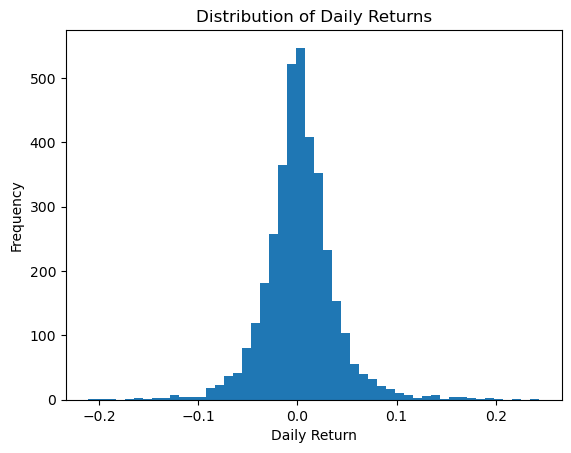

In [12]:
merged['Return'] = merged['Close'].pct_change()
returns = merged['Return'].dropna()

# Histogram
plt.figure()
plt.hist(returns, bins=50)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

# Bivariate

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [15]:
tesla['price_change_pct'] = tesla['Close'].pct_change() * 100
tesla = tesla.rename(columns={'Value': 'inflation_rate_pct'})

In [16]:
bivariate = tesla.dropna(subset=['price_change_pct', 'inflation_rate_pct']).copy()

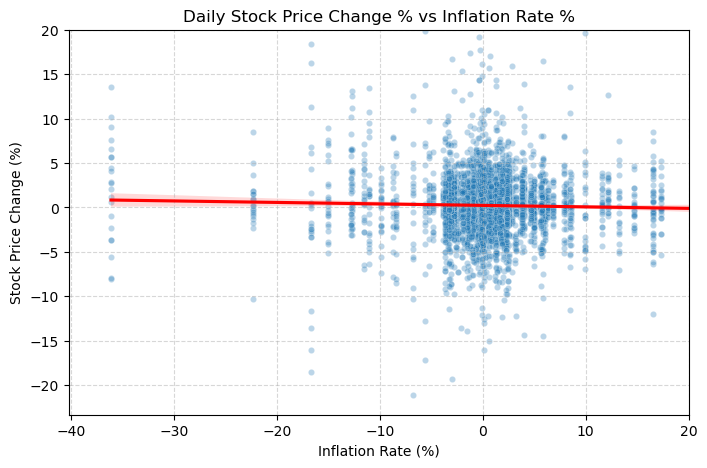

In [17]:
fig, ax = plt.subplots(figsize=(8,5))

# scatter
sns.scatterplot(
    x='inflation_rate_pct',
    y='price_change_pct',
    data=bivariate,
    alpha=0.3,
    s=20,
    ax=ax
)

# regression line
sns.regplot(
    x='inflation_rate_pct',
    y='price_change_pct',
    data=bivariate,
    scatter=False,
    ax=ax,
    color='red'
)

# force both axes to go up to 100
ax.set_xlim(right=20)
ax.set_ylim(top=20)

# add grid lines
ax.grid(True, linestyle='--', alpha=0.5)

# labels and title
ax.set(
    title='Daily Stock Price Change % vs Inflation Rate %',
    xlabel='Inflation Rate (%)',
    ylabel='Stock Price Change (%)'
)

plt.show()

# Time Series Forecasting

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [20]:
tesla_2019

,Date,Close,High,Low,Open,Volume,Value,Quarter,EPS,Revenue
2142,2019-01-02,20.674667,21.008667,19.920000,20.406668,174879000,0.1,1,-0.27,4541.0
2143,2019-01-03,20.024000,20.626667,19.825333,20.466667,104478000,0.1,1,-0.27,4541.0
2144,2019-01-04,21.179333,21.200001,20.181999,20.400000,110911500,0.1,1,-0.27,4541.0
2145,2019-01-07,22.330667,22.449333,21.183332,21.448000,113268000,0.1,1,-0.27,4541.0
2146,2019-01-08,22.356667,22.934000,21.801332,22.797333,105127500,0.1,1,-0.27,4541.0
...,...,...,...,...,...,...,...,...,...,...
2389,2019-12-24,28.350000,28.364668,27.512667,27.890667,120820500,-3.9,4,0.05,7384.0
2390,2019-12-26,28.729334,28.898666,28.423332,28.527332,159508500,-3.9,4,0.05,7384.0
2391,2019-12-27,28.691999,29.020666,28.407333,29.000000,149185500,-3.9,4,0.05,7384.0
2392,2019-12-30,27.646667,28.600000,27.284000,28.586000,188796000,-3.9,4,0.05,7384.0


In [21]:
tesla_ts = tesla.copy()

In [22]:
tesla_ts['Date'] = pd.to_datetime(tesla_ts['Date'])
tesla_ts = tesla_ts.set_index('Date').sort_index()

In [23]:
tesla_ts.loc['2010-06-01':'2010-09-01']

,Close,High,Low,Open,Volume,inflation_rate_pct,Quarter,EPS,Revenue,price_change_pct
Date,,,,,,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500,0.3,2,-0.34,28.0,NaN
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500,0.3,2,-0.34,28.0,-0.251148
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000,0.1,3,-0.03,31.0,-7.847274
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000,0.1,3,-0.03,31.0,-12.568307
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500,0.1,3,-0.03,31.0,-16.093748
2010-07-07,1.053333,1.108667,0.998667,1.093333,103825500,0.1,3,-0.03,31.0,-1.924298
2010-07-08,1.164000,1.168000,1.038000,1.076000,115671000,0.1,3,-0.03,31.0,10.506363
2010-07-09,1.160000,1.193333,1.103333,1.172000,60759000,0.1,3,-0.03,31.0,-0.343648
2010-07-12,1.136667,1.204667,1.133333,1.196667,33037500,0.1,3,-0.03,31.0,-2.011462


In [24]:
quarterly_avg = tesla_ts.resample('Q').mean()
quarterly_avg = quarterly_avg.asfreq('Q')

/var/folders/26/v6bry8wj6yn17rfht8413jyr0000gn/T/ipykernel_33907/1918829014.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_avg = tesla_ts.resample('Q').mean()
/var/folders/26/v6bry8wj6yn17rfht8413jyr0000gn/T/ipykernel_33907/1918829014.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_avg = quarterly_avg.asfreq('Q')


In [25]:
display(quarterly_avg)

,Close,High,Low,Open,Volume,inflation_rate_pct,Quarter,EPS,Revenue,price_change_pct
Date,,,,,,,,,,
2010-06-30,1.590667,1.847334,1.361333,1.493000,2.696505e+08,0.300000,2.0,-0.34,28.0,-0.251148
2010-09-30,1.328656,1.373187,1.293125,1.341563,2.288904e+07,0.550000,3.0,-0.03,31.0,-0.134191
2010-12-31,1.782510,1.829542,1.730990,1.781615,1.681777e+07,-0.089063,4.0,0.43,36.0,0.520282
2011-03-31,1.614516,1.646269,1.581570,1.617634,2.184360e+07,0.095161,1.0,-0.03,49.0,0.125833
2011-06-30,1.816550,1.858466,1.779228,1.824212,2.380262e+07,-2.834921,2.0,-0.04,58.0,0.118483
2011-09-30,1.724927,1.769625,1.685604,1.731031,1.554827e+07,-3.206250,3.0,-0.04,58.0,-0.225893
2011-12-31,1.990190,2.025079,1.937058,1.977852,1.634236e+07,-3.233333,4.0,-0.05,39.0,0.301381
2012-03-31,2.129398,2.168634,2.082097,2.127290,1.716944e+07,-2.629032,1.0,-0.06,30.0,0.507379
2012-06-30,2.105831,2.158233,2.064254,2.117630,1.977745e+07,-0.150794,2.0,-0.07,27.0,-0.215306


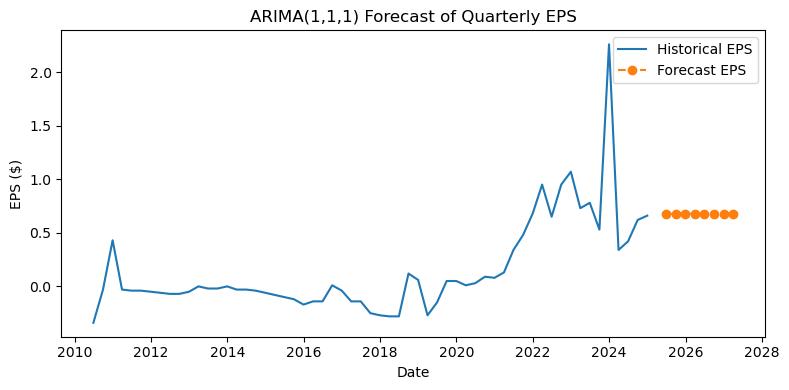

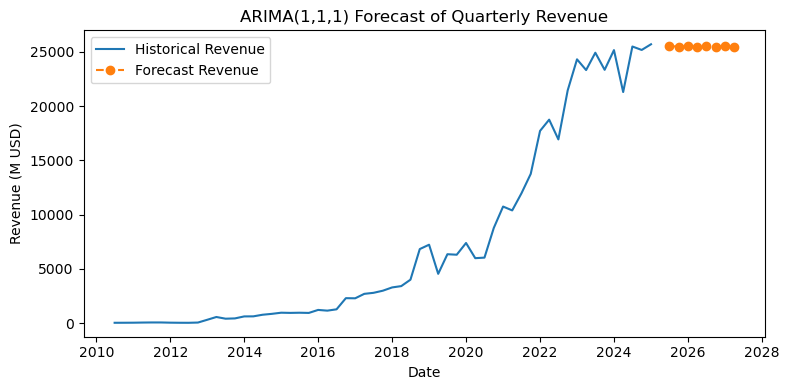

In [26]:
eps = quarterly_avg['EPS'].astype(float)
rev = quarterly_avg['Revenue'].astype(float)

# 3) Fit ARIMA(1,1,1) & forecast for EPS
model_eps = sm.tsa.ARIMA(eps, order=(1,1,1)).fit()
eps_fc = model_eps.get_forecast(8).predicted_mean

# Plot EPS
plt.figure(figsize=(8,4))
plt.plot(eps, label='Historical EPS')
plt.plot(eps_fc, marker='o', linestyle='--', label='Forecast EPS')
plt.title('ARIMA(1,1,1) Forecast of Quarterly EPS')
plt.xlabel('Date')
plt.ylabel('EPS ($)')
plt.legend()
plt.tight_layout()
plt.show()

# 4) Fit ARIMA(1,1,1) & forecast for Revenue
model_rev = sm.tsa.ARIMA(rev, order=(1,1,1)).fit()
rev_fc = model_rev.get_forecast(8).predicted_mean

# Plot Revenue
plt.figure(figsize=(8,4))
plt.plot(rev, label='Historical Revenue')
plt.plot(rev_fc, marker='o', linestyle='--', label='Forecast Revenue')
plt.title('ARIMA(1,1,1) Forecast of Quarterly Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue (M USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Hypothesis Testing 

In [28]:
import numpy as np
from scipy import stats

#Drop any NaNs in Return or Value
df = merged.dropna(subset=['Return','Value']).copy()

#Compute the median monthly Value
median_val = df['Value'].median()
print(f"Median BEA Value = {median_val:.3f}")

#Label each row high vs low inflation
df['Inflation_Group'] = np.where(df['Value'] > median_val, 'High', 'Low')

#Extract the two samples of returns
ret_high = df.loc[df['Inflation_Group']=='High', 'Return']
ret_low  = df.loc[df['Inflation_Group']=='Low',  'Return']

#Two‐sample t‐test (assuming unequal variances)
t_stat, p_val = stats.ttest_ind(ret_high, ret_low, equal_var=False)
print(f"t = {t_stat:.3f}, p = {p_val:.3f}")

#Conclusion at α = 0.05
alpha = 0.05
conclusion = "reject H₀" if p_val < alpha else "fail to reject H₀"
print(f"At α={alpha}, we {conclusion}.")

Median BEA Value = 0.100
t = -0.656, p = 0.512
At α=0.05, we fail to reject H₀.


In [29]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Prepare the data
# (Assumes `merged` already has ['Return','Value'] and no NaNs in those cols)
df = merged.dropna(subset=['Return','Value']).copy()

# Create binary target: 1 if next-day return > 0, else 0
df['Direction'] = (df['Return'] > 0).astype(int)

# Feature matrix X and target y
X = df[['Value']].values      # monthly inflation as predictor
y = df['Direction'].values    # 1 = up, 0 = down

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Fit logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# 4) Predict & evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {acc:.3f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=["Down","Up"]))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Optional: show coefficient
coef = clf.coef_[0][0]
intercept = clf.intercept_[0]

Accuracy on test set: 0.517

Classification report:
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00       353
          Up       0.52      1.00      0.68       378

    accuracy                           0.52       731
   macro avg       0.26      0.50      0.34       731
weighted avg       0.27      0.52      0.35       731

Confusion matrix:
[[  0 353]
 [  0 378]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
